# Analysis of SARS-CoV-2 specific T-cell receptors in ImmuneCode reveals cross-reactivity to immunodominant Influenza M1 epitope

In this jupyter notebook, we will walk through how to generate the results presented in the manuscript by Sidhom & Baras. Before running this analysis, the Parse_Data.py file in scripts will take provided data from the first ImmuneCode Release and parse it into a dataframe/csv file for all analyses herein.

First load imports.


In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import fisher_exact
from scripts.utils import delta_bar_plots, BarPlot, BarPlotCohort, Make_Logo
from statsmodels.stats.multitest import multipletests
import matplotlib
matplotlib.rc('font', family='Arial')
import warnings
warnings.filterwarnings('ignore')

Import data from pre-processed dataframe.

In [13]:
pept_detail = pd.read_csv('Data/data_parsed.csv')

In [14]:
pept_detail.head()

,beta_sequences,peptide,Experiment,Subject,Cohort,orf,orf_name
0,CASSLRGRLNTEAFF,ADAGFIKQY,eHO124,s_3819,Healthy (No known exposure),KDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQY,surface glycoprotein
1,CASSLRGRLNTEAFF,AELEGIQY,eHO124,s_3819,Healthy (No known exposure),ORF1ab,ORF1ab
2,CASSLRGRLNTEAFF,LADAGFIKQY,eHO124,s_3819,Healthy (No known exposure),KDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQY,surface glycoprotein
3,CASSLRGRLNTEAFF,TLADAGFIK,eHO124,s_3819,Healthy (No known exposure),KDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQY,surface glycoprotein
4,CASSLDGLTRSSYNSPLHF,ADAGFIKQY,eHO124,s_3819,Healthy (No known exposure),KDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQY,surface glycoprotein


Now we will import data from McPas-TCR, select for human TCRs that are known to recognize pathogens and cross-reference these with the TCRs in the ImmuneCode database.

In [15]:
# load mcpas data
mcpas = pd.read_csv('Data/McPAS-TCR.csv', low_memory=False, encoding='iso-8859-1')
# filter for human with missing data
mcpas = mcpas.loc[(mcpas['Species'] == 'Human') & ~mcpas['CDR3.beta.aa'].isna() & ~mcpas['Epitope.peptide'].isna() & (mcpas['Category'] == 'Pathogens'), ]
# remove duplicates
mcpas = mcpas.loc[~mcpas[['CDR3.beta.aa', 'Epitope.peptide']].duplicated(), :]

# number of unique tcr common to both mcpas and covid
total_intersection = len(np.intersect1d(mcpas['CDR3.beta.aa'],pept_detail['beta_sequences']))

print('Unique TCRs shared = ' +str(total_intersection))

Unique TCRs shared = 65


The following code first computes the background distrution of TCRs across all epitopes in the McPasTCR database. Then this distribution is filtered by those that were also present in the Immunecode database to visualize the distribution of SARS-CoV-2 specific TCRs across the known epitopes in McPas-TCR. Finally, the delta of these distributions is calculated to highlight notable shifts in the distribution suggesting a bias that would be interesting to look at. Finally, a fisher's exact test is conducted on all epitopes to look for changes in distribution that are statistically significant.

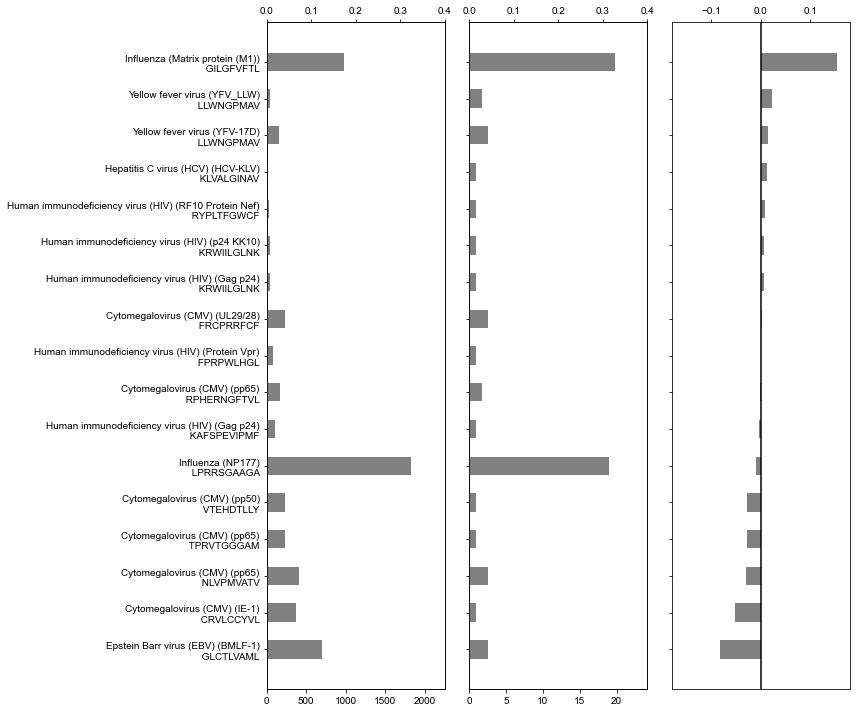

In [16]:
# count unique mcpas records that were found in ImmunoCode COVID screen
mcpas_covid = pd.concat([mcpas.groupby(['Pathology', 'Antigen.protein', 'Epitope.peptide']).size(),
                         mcpas.loc[mcpas['CDR3.beta.aa'].isin(pept_detail['beta_sequences']), :].groupby(['Pathology', 'Antigen.protein', 'Epitope.peptide']).size()],
                        axis=1).fillna(0).rename(columns={0: 'baseline', 1: 'covid'})

# limit to records seen in ImmuneCode COVID screen
mcpas_covid = mcpas_covid.loc[mcpas_covid['covid'] > 0, :]
mcpas_covid['not_covid'] = mcpas_covid['baseline'] - mcpas_covid['covid']

# get proportions
mcpas_covid['baseline_prop'] = mcpas_covid['baseline'] / mcpas_covid['baseline'].sum()
mcpas_covid['covid_prop'] = mcpas_covid['covid'] / mcpas_covid['covid'].sum()
mcpas_covid['delta'] = mcpas_covid['covid_prop'] - mcpas_covid['baseline_prop']

# sort and release multiindex
mcpas_covid = mcpas_covid.sort_values('delta').reset_index()

# fishers
mcpas_covid['fisher_p'] = None
for idx in mcpas_covid.index:
    idx_bool = mcpas_covid.index == idx
    mcpas_covid.loc[idx, 'fisher_p'] = fisher_exact(np.stack([mcpas_covid.loc[idx_bool, ['covid', 'not_covid']].sum(axis=0).values,
                                                              mcpas_covid.loc[~idx_bool, ['covid', 'not_covid']].sum(axis=0).values], axis=1), alternative='greater')[1]
mcpas_covid['fdr_bh'] = multipletests(mcpas_covid['fisher_p'], alpha=0.05, method='fdr_bh')[1]

# plot
delta_bar_plots(baseline=mcpas_covid[['baseline', 'baseline_prop']].values,
                signal=mcpas_covid[['covid', 'covid_prop']].values,
                yticklabels = mcpas_covid['Pathology'] + ' (' + mcpas_covid['Antigen.protein'] + ')\n ' + mcpas_covid['Epitope.peptide'],
                max_proporption=.4, max_delta=0.18)
# resize then call
plt.tight_layout()
plt.savefig('Results/1A.eps')

As can be seen here, the M1 Influenza epitope notably stands out with a high delta when comparing the background distribution to the SARS-CoV-2 specific distribution, suggesting a candidate for cross reactiivity between SARS-CoV-2 specific TCRs and this epitope. Additionally, fisher's exact test is statistically significant for this enrichment

In [17]:
mcpas_covid

,Pathology,Antigen.protein,Epitope.peptide,baseline,covid,not_covid,baseline_prop,covid_prop,delta,fisher_p,fdr_bh
0,Epstein Barr virus (EBV),BMLF-1,GLCTLVAML,828,3.0,825.0,0.125284,0.042857,-0.082427,0.995,0.995
1,Cytomegalovirus (CMV),IE-1,CRVLCCYVL,435,1.0,434.0,0.065819,0.014286,-0.051534,0.991703,0.995
2,Cytomegalovirus (CMV),pp65,NLVPMVATV,480,3.0,477.0,0.072628,0.042857,-0.029771,0.892614,0.995
3,Cytomegalovirus (CMV),pp65,TPRVTGGGAM,274,1.0,273.0,0.041459,0.014286,-0.027173,0.949202,0.995
4,Cytomegalovirus (CMV),pp50,VTEHDTLLY,273,1.0,272.0,0.041307,0.014286,-0.027022,0.948634,0.995
5,Influenza,NP177,LPRRSGAAGA,2142,22.0,2120.0,0.324103,0.314286,-0.009818,0.614451,0.949606
6,Human immunodeficiency virus (HIV),Gag p24,KAFSPEVIPMF,123,1.0,122.0,0.018611,0.014286,-0.004325,0.733405,0.995
7,Cytomegalovirus (CMV),pp65,RPHERNGFTVL,191,2.0,189.0,0.028900,0.028571,-0.000329,0.605633,0.949606
8,Human immunodeficiency virus (HIV),Protein Vpr,FPRPWLHGL,88,1.0,87.0,0.013315,0.014286,0.000971,0.610655,0.949606
9,Cytomegalovirus (CMV),UL29/28,FRCPRRFCF,266,3.0,263.0,0.040248,0.042857,0.002609,0.539666,0.949606


Next, we can examine the distribution of these M1 epitope specific TCRs within the ImmuneCode database across the various open reading frames (orfs). First, we will visualize the background distribution of TCRs across all orfs and then visualize the distribution of M1 spefific TCRs. Finally, we will use fisher's exact test to select changes in the distribution that would be suggestive that these M1 specific TCRs are mapping to one region in the SARS-CoV-2 genome.

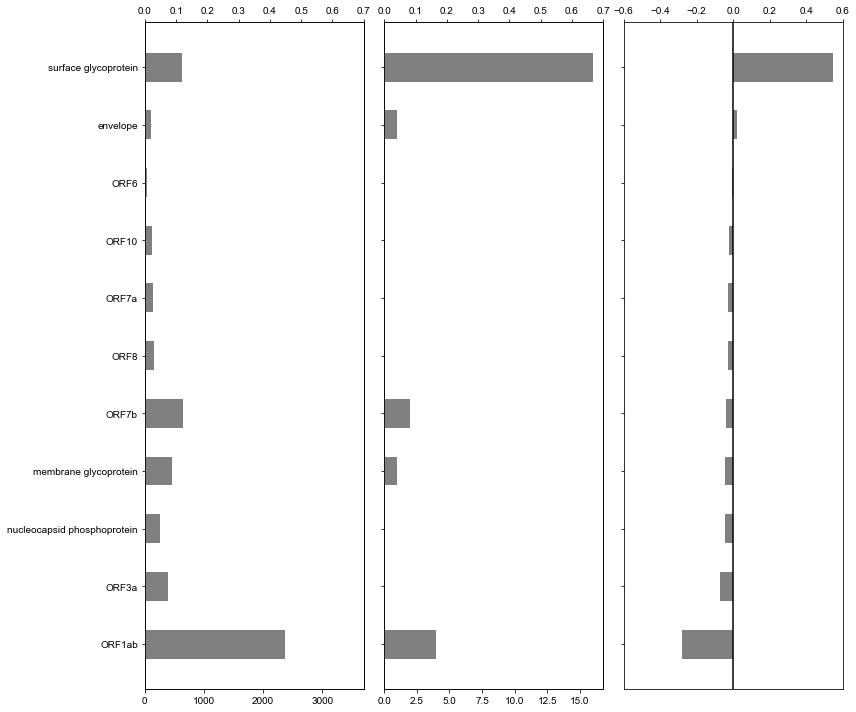

In [18]:
# unique CDR3 ORF records
pept_covid_orf_uniq = ~pept_detail[['beta_sequences', 'orf_name']].duplicated()

pept_idx = 'GILGFVFTL'
covid_orf_counts = pd.concat([pept_detail.loc[pept_covid_orf_uniq, :].groupby('orf_name').size(),
                              pept_detail.loc[pept_covid_orf_uniq & pept_detail['beta_sequences'].isin(mcpas.loc[mcpas['Epitope.peptide'] == pept_idx, 'CDR3.beta.aa']), :].groupby('orf_name').size()],
                             axis=1).fillna(0).reset_index()

covid_orf_counts.columns = ['orf_name', 'baseline', 'orf']
covid_orf_counts['not_orf'] = covid_orf_counts['baseline'] - covid_orf_counts['orf']
covid_orf_counts['baseline_prop'] = covid_orf_counts['baseline'] / covid_orf_counts['baseline'].sum()
covid_orf_counts['orf_prop'] = covid_orf_counts['orf'] / covid_orf_counts['orf'].sum()
covid_orf_counts['delta'] = covid_orf_counts['orf_prop'] - covid_orf_counts['baseline_prop']
covid_orf_counts = covid_orf_counts.sort_values('delta')

# fishers
covid_orf_counts['fisher_p'] = None
for idx in covid_orf_counts.index:
    idx_bool = covid_orf_counts.index == idx
    covid_orf_counts.loc[idx, 'fisher_p'] = fisher_exact(np.stack([covid_orf_counts.loc[idx_bool, ['orf', 'not_orf']].sum(axis=0).values,
                                                                   covid_orf_counts.loc[~idx_bool, ['orf', 'not_orf']].sum(axis=0).values], axis=1), alternative='greater')[1]
covid_orf_counts['fdr_bh'] = multipletests(covid_orf_counts['fisher_p'], alpha=0.05, method='fdr_bh')[1]

# plot
delta_bar_plots(baseline=covid_orf_counts[['baseline', 'baseline_prop']].values,
                signal=covid_orf_counts[['orf', 'orf_prop']].values,
                yticklabels = covid_orf_counts['orf_name'],
                max_proporption=.7, max_delta=0.6)
# resize then call
plt.tight_layout()
plt.savefig('Results/1B.eps')

As we can see, there is a statistically significant enrichment for these M1 specific TCRs to the surface glycoprotein orf.

In [19]:
covid_orf_counts


,orf_name,baseline,orf,not_orf,baseline_prop,orf_prop,delta,fisher_p,fdr_bh
1,ORF1ab,3520,4.0,3516.0,0.447552,0.166667,-0.280886,0.999178,1
2,ORF3a,583,0.0,583.0,0.074126,0.000000,-0.074126,1,1
9,nucleocapsid phosphoprotein,376,0.0,376.0,0.047807,0.000000,-0.047807,1,1
8,membrane glycoprotein,673,1.0,672.0,0.085569,0.041667,-0.043902,0.883535,1
5,ORF7b,972,2.0,970.0,0.123586,0.083333,-0.040252,0.815542,1
6,ORF8,219,0.0,219.0,0.027845,0.000000,-0.027845,1,1
4,ORF7a,213,0.0,213.0,0.027082,0.000000,-0.027082,1,1
0,ORF10,185,0.0,185.0,0.023522,0.000000,-0.023522,1,1
3,ORF6,43,0.0,43.0,0.005467,0.000000,-0.005467,1,1
7,envelope,154,1.0,153.0,0.019580,0.041667,0.022086,0.378298,1


Now we can better identify which epitopes within the surface glycoprotein are mapping to these M1 specific TCRs. First, we will map all SARS-CoV-2 epitopes to known TCR/epitope pairs in McPas-TCR and select for the M1 specific TCRs. We will then tabulte the unique TCRs per epitope and visualize this via a bar plot.

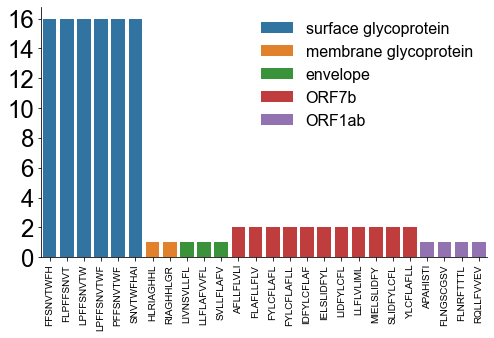

In [20]:
data = pd.merge(pept_detail, mcpas[['CDR3.beta.aa', 'Pathology', 'Antigen.protein', 'Epitope.peptide']],
                                  how='inner', left_on='beta_sequences', right_on='CDR3.beta.aa')

data_sel = data[data['Epitope.peptide']==pept_idx]
data_sel.drop_duplicates(subset=['beta_sequences','peptide'],inplace=True)
data_sel['counts']=1
df_agg = data_sel.groupby(['peptide', 'orf_name']).agg({'counts': 'sum'}).reset_index()
df_agg.sort_values(by=['orf_name','peptide'],inplace=True,ascending=[False,True])
df_agg.reset_index(drop=True,inplace=True)
leg = BarPlot(df_agg)
plt.savefig('Results/1C.eps')

We notice a strong bias towards a set of epitopes in the surface glycoprotein orf with a converved SNVT motif. We then can select for these 16 TCRs that map to these set of epitopes and create a seq logo to visualize their level of homology.

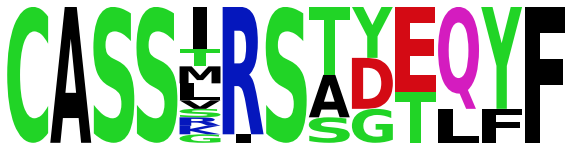

In [21]:
sel_seq = np.unique(data_sel[data_sel['peptide'].isin(df_agg['peptide'][0:5])]['beta_sequences'])
ax = Make_Logo(sel_seq)
ax.fig.savefig('Results/1C_logo.eps')

Finally, we can query the number of individuals who expanded these M1 specific cross-reactive TCRs to these SARS-CoV-2 epitopes.

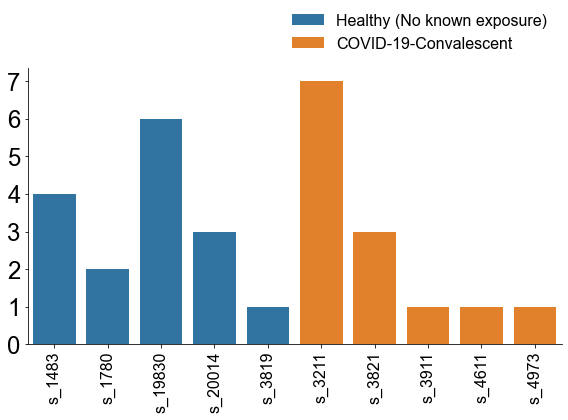

In [22]:
data_sel = data[data['Epitope.peptide']==pept_idx]
data_sel.drop_duplicates(subset=['beta_sequences','Subject'],inplace=True)
data_sel['counts']=1
df_agg = data_sel.groupby(['Subject']).agg({'Cohort':'first','counts':'sum'}).reset_index()
leg = BarPlotCohort(df_agg)
bbox_to_anchor=[1.0, 1.25]
leg.set_bbox_to_anchor(bbox_to_anchor)
plt.tight_layout()
plt.savefig('Results/1D.eps')

